# Big Data Analytics: Maharashtra Livestock Census

This project performs an in-depth analysis of the 19th Livestock and Poultry Census data for Maharashtra, broken down by tehsil (block). We will use PySpark to handle and process the data, demonstrating a typical big data workflow.

**Project Goals:**
1.  Load and clean the raw census data.
2.  Perform Exploratory Data Analysis (EDA) to understand the distribution of livestock and poultry across different districts and tehsils.
3.  Identify key insights, such as top districts for livestock/poultry and the overall composition of the livestock population.
4.  Visualize the findings for clear and effective communication.

### 1. Environment Setup

First, we import the necessary libraries and initialize a SparkSession, which is the entry point for any PySpark application.

In [78]:
import re
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, sum, desc
from pyspark.sql.types import IntegerType
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Create a SparkSession
spark = SparkSession.builder \
    .appName("MaharashtraLivestockAnalysis") \
    .getOrCreate()

### 2. Data Loading

We load the provided CSV file into a Spark DataFrame. We instruct Spark to infer the schema and treat the first row as the header.

In [79]:
file_path = 'Maharashtra_19th_Livestock_Poultry_Census_Tehsilwise_18.9.25.csv'

# Added multiLine=True to handle cases where a single field might contain newline characters.
df = spark.read.csv(file_path, header=True, inferSchema=True, multiLine=True)

### 3. Initial Data Exploration

Let's get a first look at our data. We'll check the schema to see the data types Spark inferred and display a few rows to understand the structure.

In [80]:
# Print the schema
print("DataFrame Schema:")
df.printSchema()

# Show the first 5 rows
print("\nSample Data:")
df.show(5, truncate=False)

DataFrame Schema:
root
 |-- Sr. No.: integer (nullable = true)
 |-- Name of the District: string (nullable = true)
 |-- Tahsil/Block: string (nullable = true)
 |-- Cattle- exotic/crossbred : integer (nullable = true)
 |-- Cattle-indigenous : integer (nullable = true)
 |-- Cattle-Total : integer (nullable = true)
 |-- buffaloes-Total: integer (nullable = true)
 |-- Sheep-exotic/crossbred: integer (nullable = true)
 |-- Sheep-indigenous: integer (nullable = true)
 |-- sheep-Total : integer (nullable = true)
 |-- Goats-Total: integer (nullable = true)
 |-- Pigs-exotic/cross bred : integer (nullable = true)
 |-- Pigs-Indigenous : integer (nullable = true)
 |--  Pigs -Total: integer (nullable = true)
 |-- horses & ponies-Total : integer (nullable = true)
 |-- Mules-Total : integer (nullable = true)
 |--  donkeys-Total: integer (nullable = true)
 |-- camels-Total  : integer (nullable = true)
 |-- Total Livestock: integer (nullable = true)
 |-- Dogs-Total : integer (nullable = true)
 |-- Rabb

### 4. Data Cleaning and Preprocessing

The column names contain spaces, special characters, and newlines, which can be problematic. We'll clean them by converting them to a consistent `snake_case` format.

Additionally, some numeric columns might be read as strings or contain null values. We will cast them to the correct integer type and fill any nulls with `0`, as nulls in this context likely represent a count of zero.

In [83]:
# Filter out any rows that appear to be headers or summary lines.
# A robust way to do this is to check if the 'Sr. No.' column can be cast to an integer.
# We must use backticks to handle the space and dot in the column name.
df_filtered = df.filter(col("`Sr. No.`").cast(IntegerType()).isNotNull())

# Function to clean column names
def clean_col_names(df):
    new_columns = []
    for c in df.columns:
        # Remove special characters and extra spaces
        clean_name = re.sub(r'[^a-zA-Z0-9_\s]', '', c).strip()
        # Replace spaces and hyphens with underscores, convert to lowercase
        clean_name = re.sub(r'[\s-]+', '_', clean_name).lower()
        new_columns.append(clean_name)
    return df.toDF(*new_columns)

df_cleaned = clean_col_names(df_filtered)

# Identify columns that should be numeric (excluding sr_no)
numeric_cols = [c for c in df_cleaned.columns if c not in ['name_of_the_district', 'tahsilblock', 'sr_no']]

# Fill nulls with 0 and cast to IntegerType
for c in numeric_cols:
    df_cleaned = df_cleaned.withColumn(c, col(c).cast(IntegerType()))

df_cleaned = df_cleaned.na.fill(0, subset=numeric_cols)

print("Cleaned DataFrame Schema:")
df_cleaned.printSchema()

print("\nSample Data after Cleaning:")
df_cleaned.show(5)

Cleaned DataFrame Schema:
root
 |-- sr_no: integer (nullable = true)
 |-- name_of_the_district: string (nullable = true)
 |-- tahsilblock: string (nullable = true)
 |-- cattle_exoticcrossbred: integer (nullable = true)
 |-- cattleindigenous: integer (nullable = true)
 |-- cattletotal: integer (nullable = true)
 |-- buffaloestotal: integer (nullable = true)
 |-- sheepexoticcrossbred: integer (nullable = true)
 |-- sheepindigenous: integer (nullable = true)
 |-- sheeptotal: integer (nullable = true)
 |-- goatstotal: integer (nullable = true)
 |-- pigsexoticcross_bred: integer (nullable = true)
 |-- pigsindigenous: integer (nullable = true)
 |-- pigs_total: integer (nullable = true)
 |-- horses_poniestotal: integer (nullable = true)
 |-- mulestotal: integer (nullable = true)
 |-- donkeystotal: integer (nullable = true)
 |-- camelstotal: integer (nullable = true)
 |-- total_livestock: integer (nullable = true)
 |-- dogstotal: integer (nullable = true)
 |-- rabbitstotal: integer (nullable =

### 4a. Saving the Cleaned Data

After preprocessing, it's a good practice to save the cleaned data. This creates a checkpoint and allows you to load the clean data directly for future analysis without repeating the cleaning steps.

In [84]:
# Save the cleaned DataFrame to a new CSV file.
# We convert to a Pandas DataFrame and use its to_csv method to avoid Hadoop winutils dependency on Windows.
cleaned_output_path = "cleaned_maharashtra_livestock.csv"
df_cleaned.toPandas().to_csv(cleaned_output_path, index=False)

print(f"Successfully saved the cleaned data to: {cleaned_output_path}")

Successfully saved the cleaned data to: cleaned_maharashtra_livestock.csv


### 5. Exploratory Data Analysis (EDA) - District Level

Now that our data is clean, we can start the analysis. We'll begin by aggregating the data at the district level to find the total livestock and poultry populations for each district in Maharashtra.

In [85]:
district_summary = df_cleaned.groupBy("name_of_the_district") \
    .agg(
        sum("total_livestock").alias("total_livestock"),
        sum("total_poultryp_farm_hatchery_birds").alias("total_poultry")
    ) \
    .orderBy(desc("total_livestock"))

print("District-wise Summary of Livestock and Poultry:")
district_summary.show(10)

# Save the district-level summary to a new CSV file.
# We convert to a Pandas DataFrame and use its to_csv method to avoid Hadoop winutils dependency on Windows.
eda_output_path = "district_summary_results.csv"
district_summary.toPandas().to_csv(eda_output_path, index=False)

print(f"\nSuccessfully saved the district summary EDA results to: {eda_output_path}")

District-wise Summary of Livestock and Poultry:
+--------------------+---------------+-------------+
|name_of_the_district|total_livestock|total_poultry|
+--------------------+---------------+-------------+
|          Ahmadnagar|        2821543|      8973914|
|              Nashik|        2246473|     15880283|
|             Solapur|        2091321|      2252238|
|                Pune|        1772448|     18537999|
|              Sangli|        1322591|      3027382|
|              Satara|        1311286|      3979611|
|                Beed|        1238324|       977573|
|             Jalgaon|        1219616|       672888|
|              Nanded|        1176467|       461485|
|            Kolhapur|        1161363|      3199328|
+--------------------+---------------+-------------+
only showing top 10 rows

Successfully saved the district summary EDA results to: district_summary_results.csv


### 6. Visualization: District-wise Livestock and Poultry

To better understand the district-level distribution, we'll convert our aggregated Spark DataFrame to a Pandas DataFrame and create bar charts.

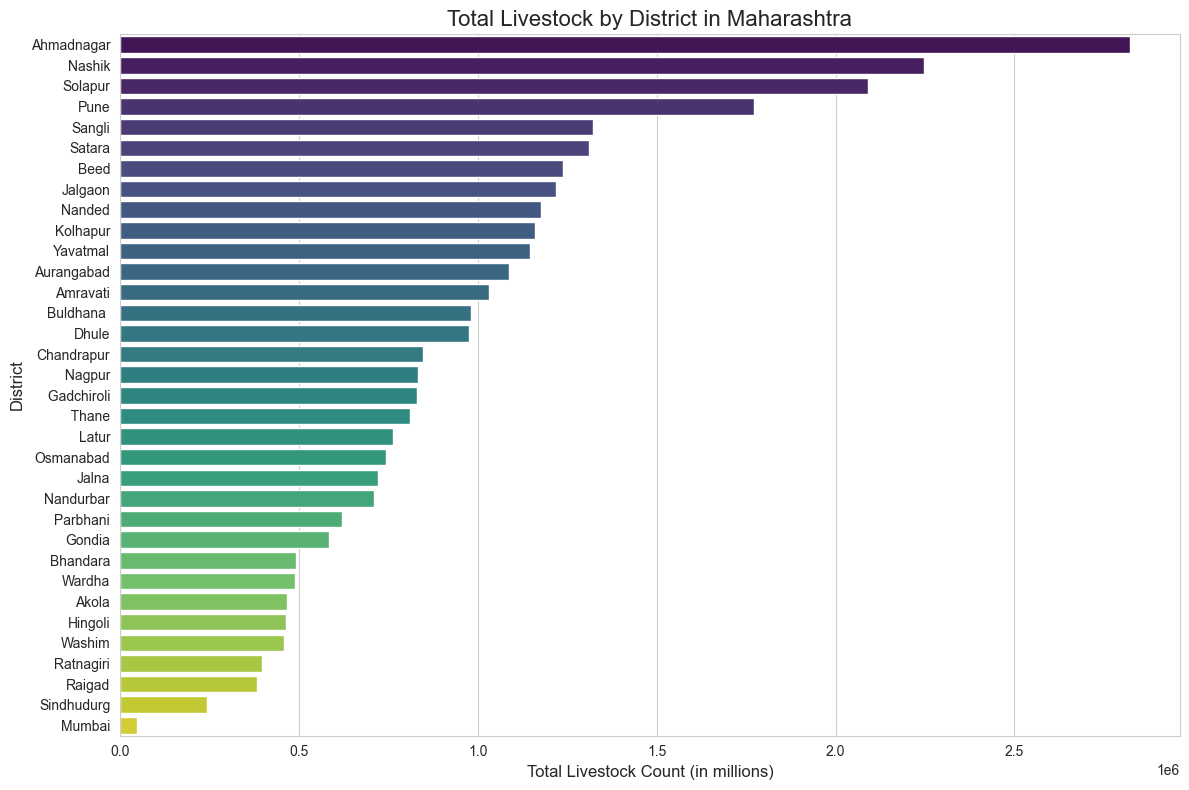

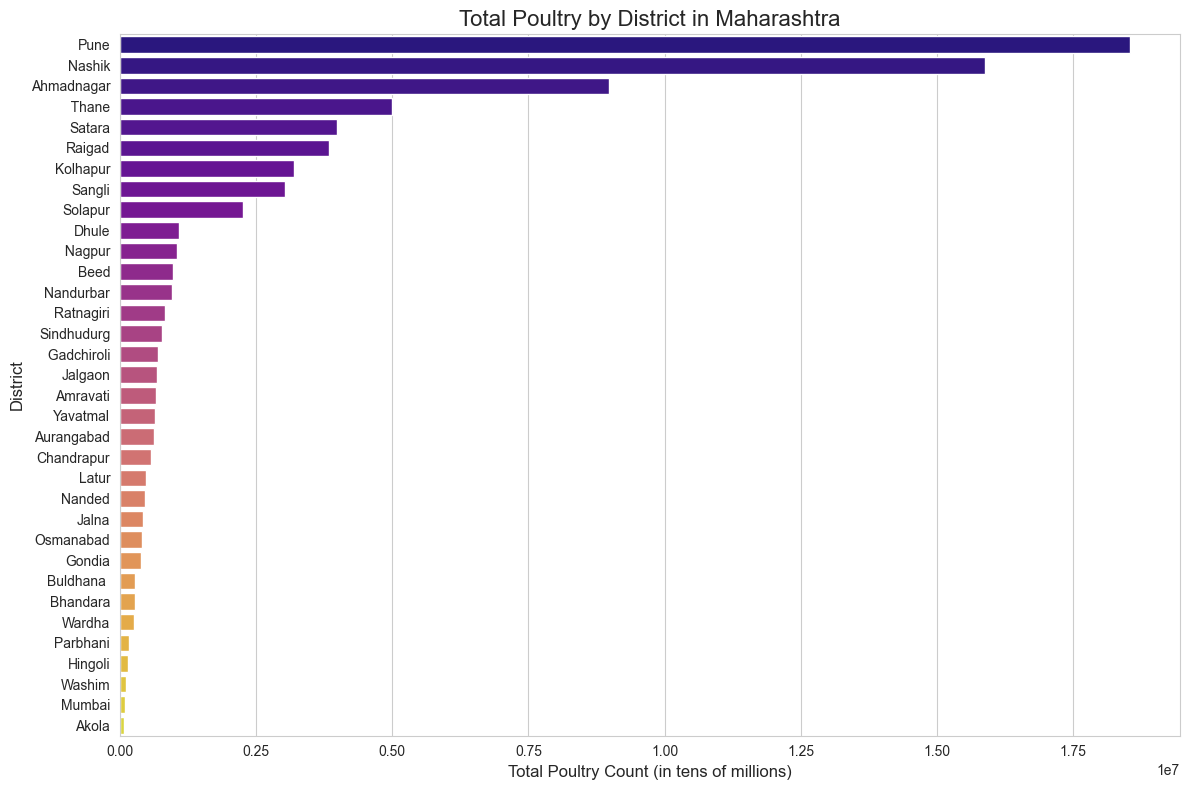

In [86]:
# Convert to Pandas for visualization
pd_district_summary = district_summary.toPandas()

# Set plot style
sns.set_style("whitegrid")

# Plot Total Livestock
plt.figure(figsize=(12, 8))
sns.barplot(data=pd_district_summary, y='name_of_the_district', x='total_livestock', hue='name_of_the_district', palette='viridis', legend=False)
plt.title('Total Livestock by District in Maharashtra', fontsize=16)
plt.xlabel('Total Livestock Count (in millions)', fontsize=12)
plt.ylabel('District', fontsize=12)
plt.tight_layout()
plt.show()

# Plot Total Poultry
plt.figure(figsize=(12, 8))
sns.barplot(data=pd_district_summary.sort_values('total_poultry', ascending=False), y='name_of_the_district', x='total_poultry', hue='name_of_the_district', palette='plasma', legend=False)
plt.title('Total Poultry by District in Maharashtra', fontsize=16)
plt.xlabel('Total Poultry Count (in tens of millions)', fontsize=12)
plt.ylabel('District', fontsize=12)
plt.tight_layout()
plt.show()

### 7. EDA - Top Tehsils (Blocks)

Next, we drill down to the tehsil level to identify the specific blocks with the highest populations of livestock and poultry.

In [87]:
# Top 10 tehsils by livestock
top_10_livestock_tehsils = df_cleaned.select("name_of_the_district", "tahsilblock", "total_livestock") \
    .orderBy(desc("total_livestock")) \
    .limit(10)

# Top 10 tehsils by poultry
top_10_poultry_tehsils = df_cleaned.select("name_of_the_district", "tahsilblock", "total_poultryp_farm_hatchery_birds") \
    .orderBy(desc("total_poultryp_farm_hatchery_birds")) \
    .limit(10)

print("Top 10 Tehsils by Total Livestock:")
top_10_livestock_tehsils.show()

print("\nTop 10 Tehsils by Total Poultry:")
top_10_poultry_tehsils.show()

Top 10 Tehsils by Total Livestock:
+--------------------+-----------+---------------+
|name_of_the_district|tahsilblock|total_livestock|
+--------------------+-----------+---------------+
|             Solapur|  Malshiras|         363436|
|          Ahmadnagar|  Sangamner|         359076|
|             Solapur|    Sangole|         357860|
|               Dhule|      Sakri|         345801|
|              Nashik|   Malegaon|         341868|
|               Dhule|      Dhule|         325930|
|              Sangli|        Jat|         302515|
|          Ahmadnagar|     Parner|         292287|
|              Satara|        Man|         264260|
|              Nashik|   Nandgaon|         254544|
+--------------------+-----------+---------------+


Top 10 Tehsils by Total Poultry:
+--------------------+-----------+----------------------------------+
|name_of_the_district|tahsilblock|total_poultryp_farm_hatchery_birds|
+--------------------+-----------+----------------------------------+
|     

### 7a. Visualization: Top Tehsils (Blocks)

Visualizing the top tehsils gives us a more granular view of where livestock and poultry farming are most concentrated.

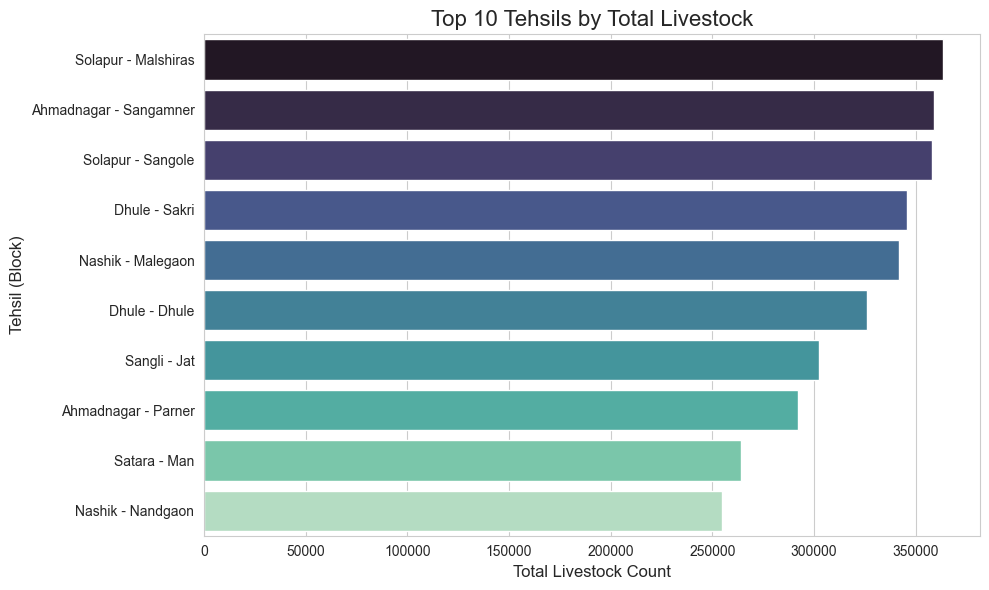

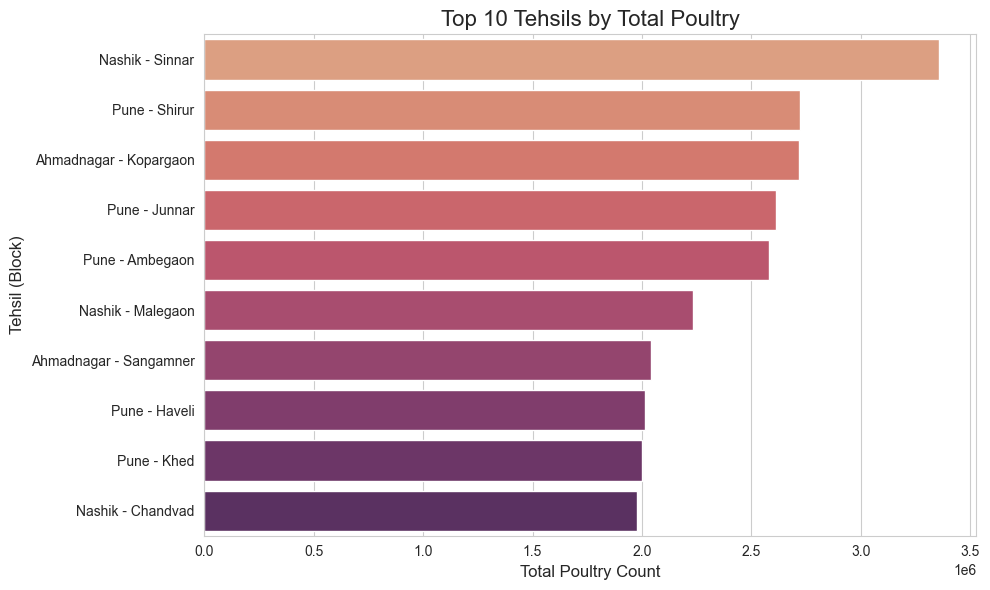

In [88]:
# Convert Spark DFs to Pandas for plotting
pd_top_livestock = top_10_livestock_tehsils.toPandas()
pd_top_poultry = top_10_poultry_tehsils.toPandas()

# Create a combined location label for clarity
pd_top_livestock['location'] = pd_top_livestock['name_of_the_district'] + ' - ' + pd_top_livestock['tahsilblock']
pd_top_poultry['location'] = pd_top_poultry['name_of_the_district'] + ' - ' + pd_top_poultry['tahsilblock']

# Plot Top 10 Tehsils by Livestock
plt.figure(figsize=(10, 6))
sns.barplot(data=pd_top_livestock, y='location', x='total_livestock', hue='location', palette='mako', legend=False)
plt.title('Top 10 Tehsils by Total Livestock', fontsize=16)
plt.xlabel('Total Livestock Count', fontsize=12)
plt.ylabel('Tehsil (Block)', fontsize=12)
plt.tight_layout()
plt.show()

# Plot Top 10 Tehsils by Poultry
plt.figure(figsize=(10, 6))
sns.barplot(data=pd_top_poultry, y='location', x='total_poultryp_farm_hatchery_birds', hue='location', palette='flare', legend=False)
plt.title('Top 10 Tehsils by Total Poultry', fontsize=16)
plt.xlabel('Total Poultry Count', fontsize=12)
plt.ylabel('Tehsil (Block)', fontsize=12)
plt.tight_layout()
plt.show()

### 8. EDA - Livestock Composition

What types of animals make up the total livestock population? We'll calculate the statewide total for each major livestock category to understand the composition.

In [89]:
livestock_composition = df_cleaned.agg(
    sum("cattletotal").alias("Cattle"),
    sum("buffaloestotal").alias("Buffaloes"),
    sum("sheeptotal").alias("Sheep"),
    sum("goatstotal").alias("Goats"),
    sum("pigs_total").alias("Pigs"),
    sum("horses_poniestotal").alias("Horses & Ponies")
).toPandas().transpose()

livestock_composition.columns = ['total_count']
livestock_composition = livestock_composition.sort_values('total_count', ascending=False)

print("Statewide Livestock Composition:")
print(livestock_composition)

Statewide Livestock Composition:
                 total_count
Cattle              15484207
Goats                8435307
Buffaloes            5594392
Sheep                2580381
Pigs                  325756
Horses & Ponies        37287


### 9. Visualization: Livestock Composition

A pie chart is an effective way to visualize the proportion of each animal category relative to the total livestock population.

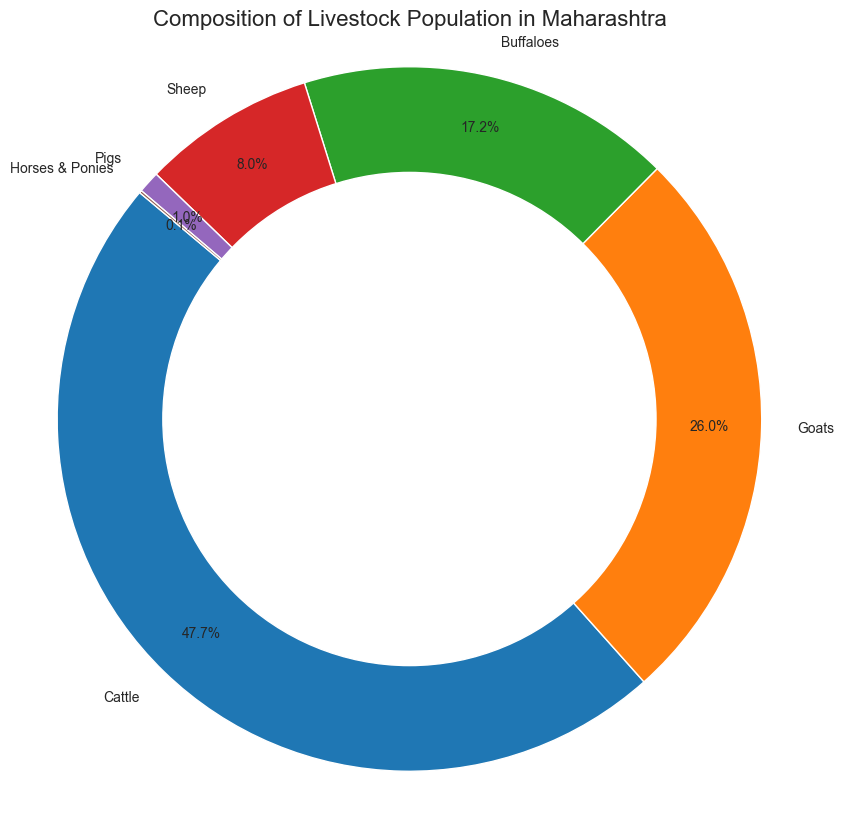

In [90]:
plt.figure(figsize=(10, 10))
plt.pie(livestock_composition['total_count'], labels=livestock_composition.index, autopct='%1.1f%%', startangle=140, pctdistance=0.85)

# Draw a circle to make it a donut chart
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.title('Composition of Livestock Population in Maharashtra', fontsize=16)
plt.axis('equal') # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

### 9a. EDA - Correlation Between Livestock Types

A heatmap can reveal if there are relationships between the populations of different livestock. For example, do areas with many cattle also have many buffaloes?

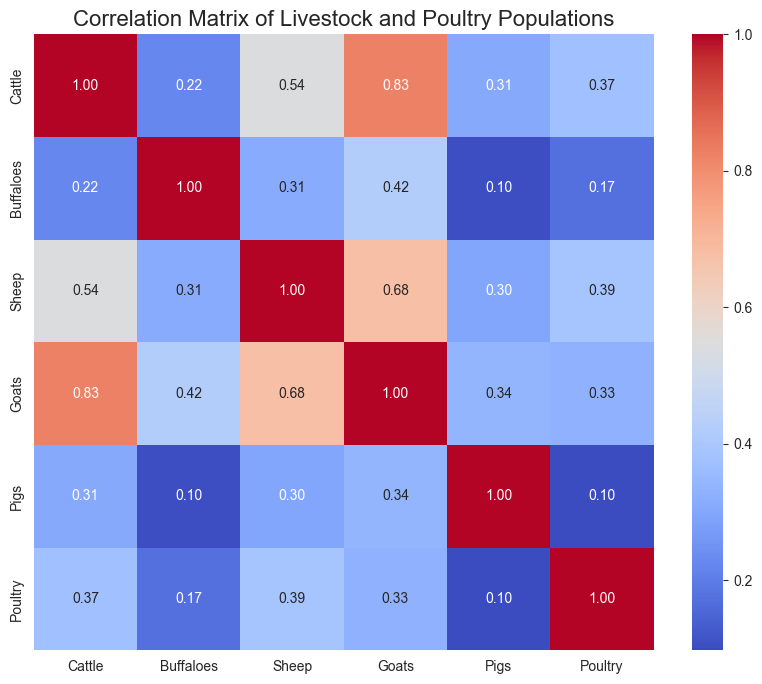

In [91]:
# Select major livestock columns for correlation analysis
correlation_df = df_cleaned[['cattletotal', 'buffaloestotal', 'sheeptotal', 'goatstotal', 'pigs_total', 'total_poultryp_farm_hatchery_birds']].toPandas()
correlation_df.columns = ['Cattle', 'Buffaloes', 'Sheep', 'Goats', 'Pigs', 'Poultry']

# Calculate the correlation matrix
corr_matrix = correlation_df.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Livestock and Poultry Populations', fontsize=16)
plt.show()

### 9b. Analysis: Indigenous vs. Crossbred Population (Cattle)

This analysis explores the composition of cattle breeds (indigenous vs. exotic/crossbred) across the top 10 cattle-producing districts. This can highlight regional preferences or policies related to cattle breeding.

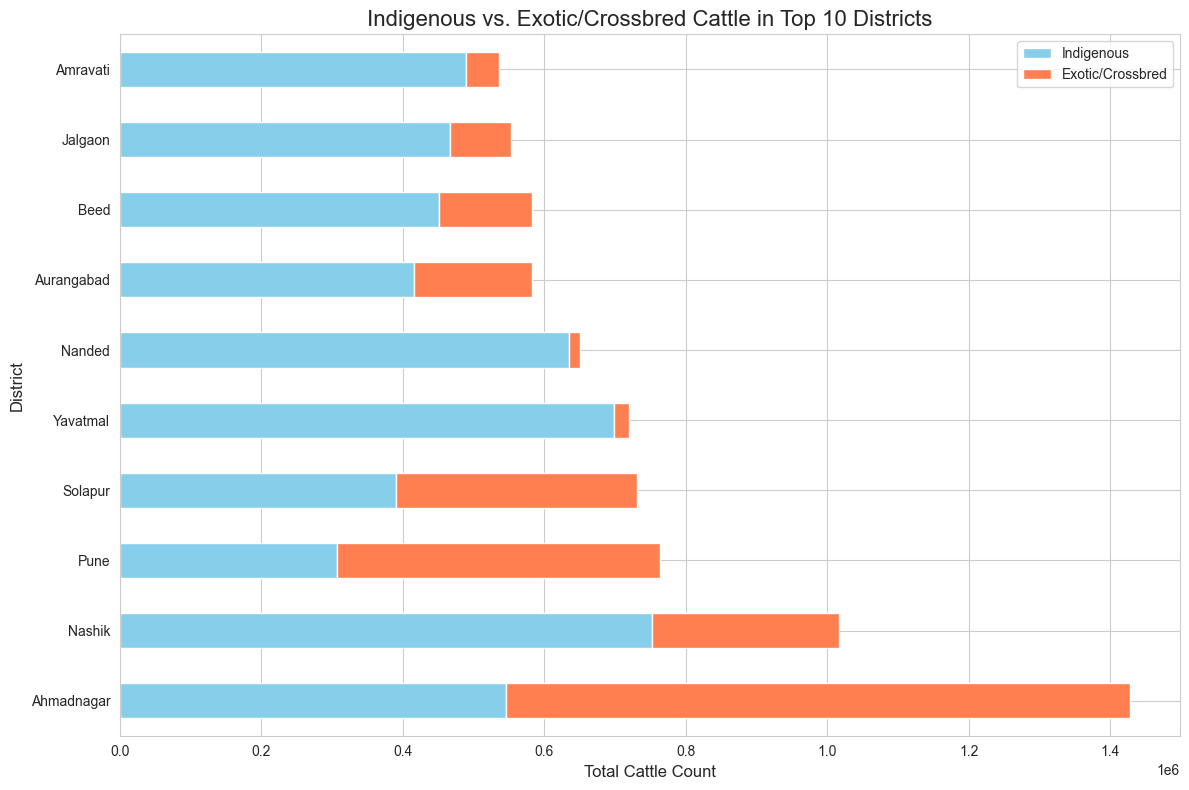

In [92]:
# Aggregate cattle breed data by district
breed_summary = df_cleaned.groupBy("name_of_the_district").agg(
    sum("cattle_exoticcrossbred").alias("exotic_crossbred_cattle"),
    sum("cattleindigenous").alias("indigenous_cattle"),
    sum("cattletotal").alias("total_cattle")
).orderBy(desc("total_cattle")).limit(10)

# Convert to Pandas for plotting
pd_breed_summary = breed_summary.toPandas()

# Plotting the stacked bar chart
pd_breed_summary.set_index('name_of_the_district')[['indigenous_cattle', 'exotic_crossbred_cattle']].plot(
    kind='barh', 
    stacked=True, 
    figsize=(12, 8), 
    color=['skyblue', 'coral']
)

plt.title('Indigenous vs. Exotic/Crossbred Cattle in Top 10 Districts', fontsize=16)
plt.xlabel('Total Cattle Count', fontsize=12)
plt.ylabel('District', fontsize=12)
plt.legend(['Indigenous', 'Exotic/Crossbred'])
plt.tight_layout()
plt.show()

### 10. Conclusion and Key Findings

This analysis provided several key insights into Maharashtra's livestock and poultry census:

1.  **Top Districts:** 
    - For **livestock**, districts like **Ahmednagar, Pune, and Solapur** are the top contributors.
    - For **poultry**, **Pune and Nashik** dominate significantly, indicating a concentration of poultry farming in these regions.

2.  **Livestock Composition:**
    - The livestock population is primarily composed of **Cattle and Goats**, which together make up the vast majority of the total.
    - Buffaloes are the next significant group, while sheep, pigs, and horses form a much smaller fraction.

3.  **Correlations and Specializations:**
    - There is a strong positive correlation between cattle and buffalo populations, suggesting that dairy farming practices often involve both.
    - Poultry farming appears to be a highly specialized activity, showing little correlation with other livestock types, especially concentrated in specific tehsils within Pune and Nashik.
    - The analysis of cattle breeds shows a significant presence of indigenous cattle across all top districts, though exotic/crossbred varieties are also substantial, particularly in districts like Ahmednagar and Pune.

This PySpark project successfully demonstrates a scalable workflow for processing and analyzing tabular data to extract meaningful and actionable insights.

### 11. Logical Recommendations

Based on the analysis, the following strategic recommendations can be made for different stakeholders:

#### For Government & Policymakers:
1.  **Targeted Resource Allocation:** Concentrate investment in veterinary services, disease surveillance, and farmer training programs in the top-producing districts. For example, establish poultry-specific support centers in Pune and Nashik, and focus on cattle and goat development schemes in Ahmednagar and Solapur.
2.  **Breed Improvement Programs:** Given the mix of indigenous and crossbred cattle, design targeted programs that either help conserve and improve indigenous breeds or provide support for farmers managing high-yield crossbred animals, depending on the district's specific composition and goals.
3.  **Infrastructure Development:** Promote the development of cold storage, processing units, and improved market linkages in high-density regions to reduce post-production losses and ensure better returns for farmers.

#### For Private Agribusiness & Investors:
1.  **Strategic Investment:** The data provides a clear map for investment. Companies dealing in poultry feed, supplements, and equipment should focus their marketing and distribution networks in and around Pune and Nashik. Similarly, businesses involved in dairy or meat processing for cattle and goats should target Ahmednagar, Pune, and Solapur.
2.  **Supply Chain Optimization:** Logistics companies can use this data to plan efficient transportation routes and establish warehouses or collection centers in key tehsils, reducing transit times and costs.
3.  **Specialized Product Development:** The breed-specific data for cattle can inform businesses that specialize in products for either indigenous or crossbred animals, such as customized feed or specific veterinary medicines.

In [1]:
# Stop the SparkSession
spark.stop()

NameError: name 'spark' is not defined